In [1]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, SLSQP
from qiskit.circuit.library import TwoLocal, ZZFeatureMap,RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 1376
algorithm_globals.random_seed = seed

In [2]:
import pandas as pd
import numpy as np
Iris_data=pd.read_csv('Iris.csv')
Iris_data.drop(['Id'], axis=1)
# print(Iris_data)
# Iris_data.head()
# import numpy as np
# d = np.loadtxt("Iris.csv", delimiter=",")

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
feature_cols = [
    'SepalLengthCm',
    'SepalWidthCm',
    'PetalLengthCm',
    'PetalWidthCm'
]

target_col = ['Species']

In [10]:
from sklearn.model_selection import train_test_split

xtrain = Iris_data[feature_cols]
ytrain = Iris_data[target_col]#.astype(int)
# ytrain = pd.get_dummies(Iris_data, columns = ['Species'])
# print(ytrain)
ytrain_new = pd.get_dummies(ytrain, columns=["Species"])
# print("The transform data using get_dummies")
# print(ytrain_new)

x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain_new, test_size=0.25, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112, 3), (38, 3))

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_25392\2843335973.py:8: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit = feature_map.combine(ansatz)


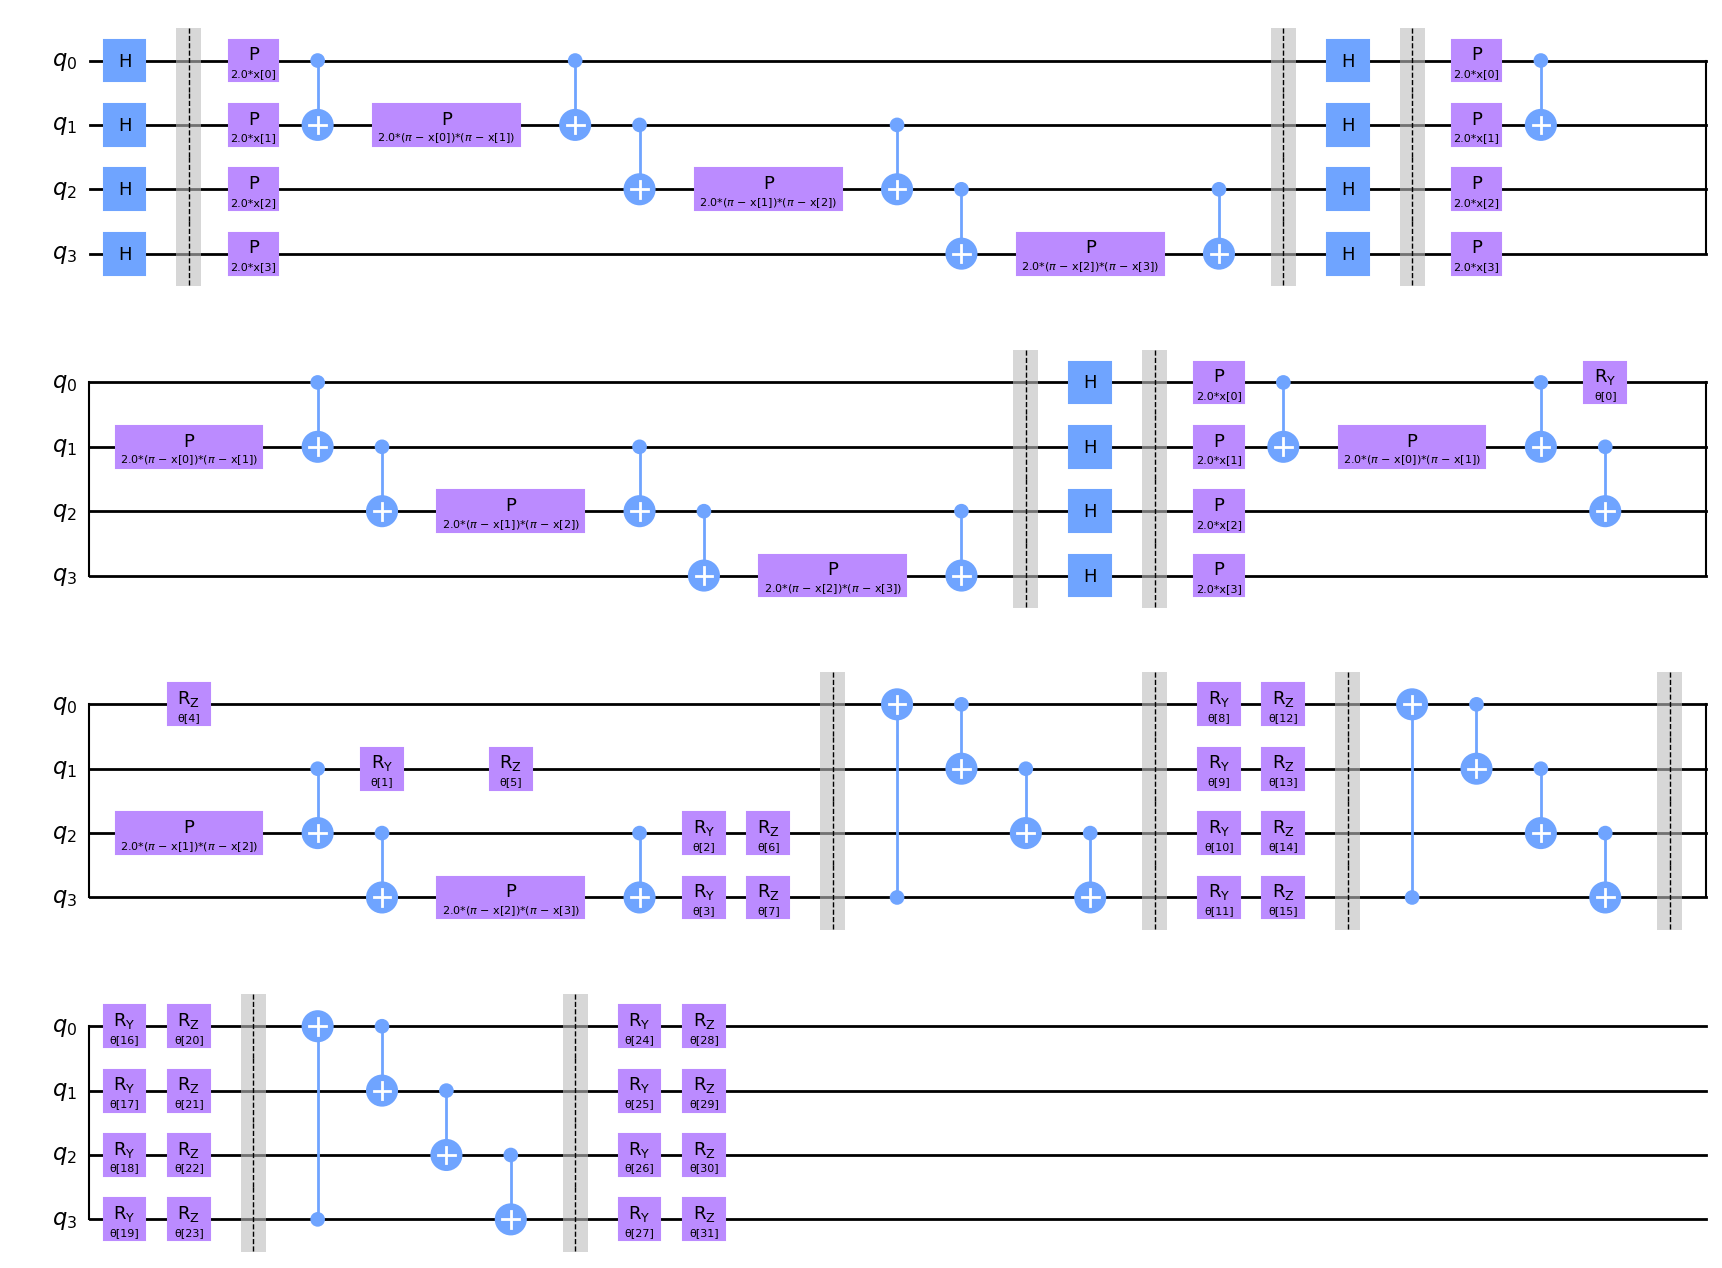

In [12]:
# sv = Statevector.from_label('0' * n)
# feature_map = ZZFeatureMap(feature_dimension=len(feature_cols), reps=2, entanglement="linear")
feature_map = ZZFeatureMap(feature_dimension=4, reps=3, entanglement='linear', insert_barriers=True)
# ansatz = RealAmplitudes(4, reps=1)
ansatz = TwoLocal(num_qubits=4, reps=3, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
# ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)
circuit = feature_map.combine(ansatz)
circuit.decompose().draw(output='mpl')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Noiseless simulation with COBYLA optimizer

In [25]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [30]:
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=250),
          quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),callback=callback_graph
          )


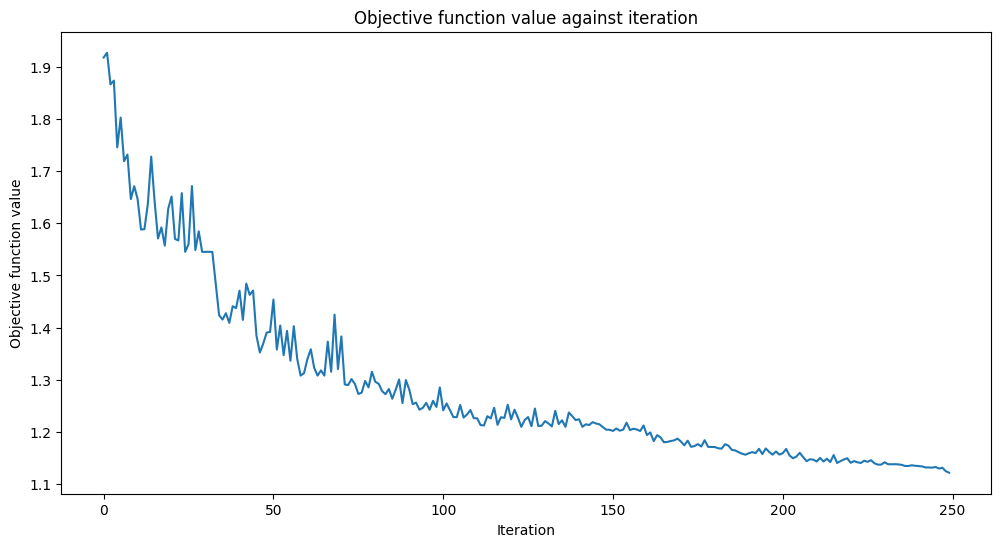

Testing accuracy: 0.76


In [31]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")

#Noisy Simulation with COBYLA Optimizer

In [41]:
import os
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=250),
          quantum_instance=qi,callback=callback_graph
          )

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_25392\2048665023.py:10: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'sx', 'x']
  Instructions with noise: ['x', 'sx', 'id', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]



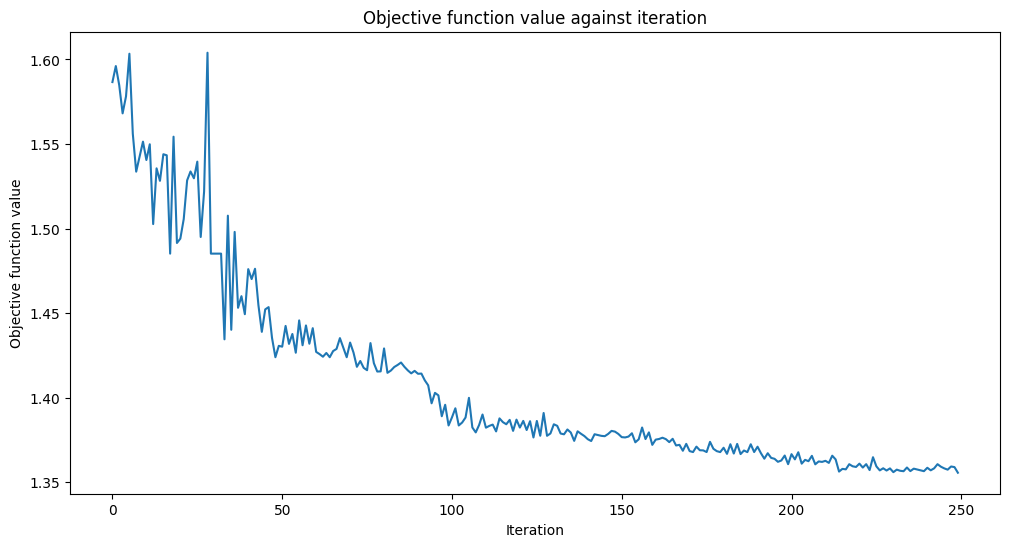

Testing accuracy: 0.76


In [43]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")

#Noisy Simulation with COBYLA optimizer with Measurement Error Mitigation

In [44]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi2 = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls=CompleteMeasFitter,
                         cals_matrix_refresh_period=30)
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=250),
          quantum_instance=qi2,callback=callback_graph
          )

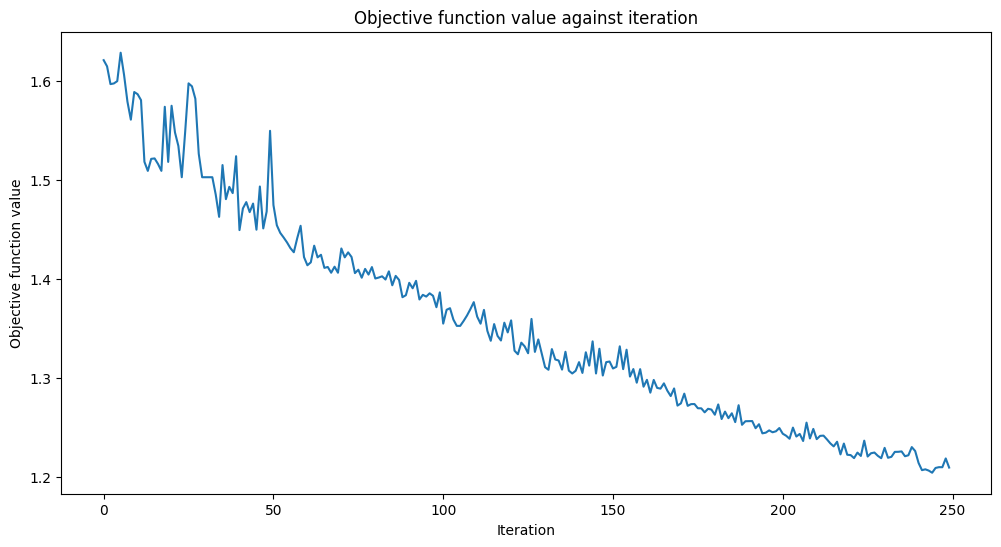

Testing accuracy: 0.76


In [45]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")

#Noiseless simulation with SPSA Optimizer

In [28]:
from qiskit.algorithms.optimizers import SPSA


vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SPSA(maxiter=100),
          quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),callback=callback_graph
          )

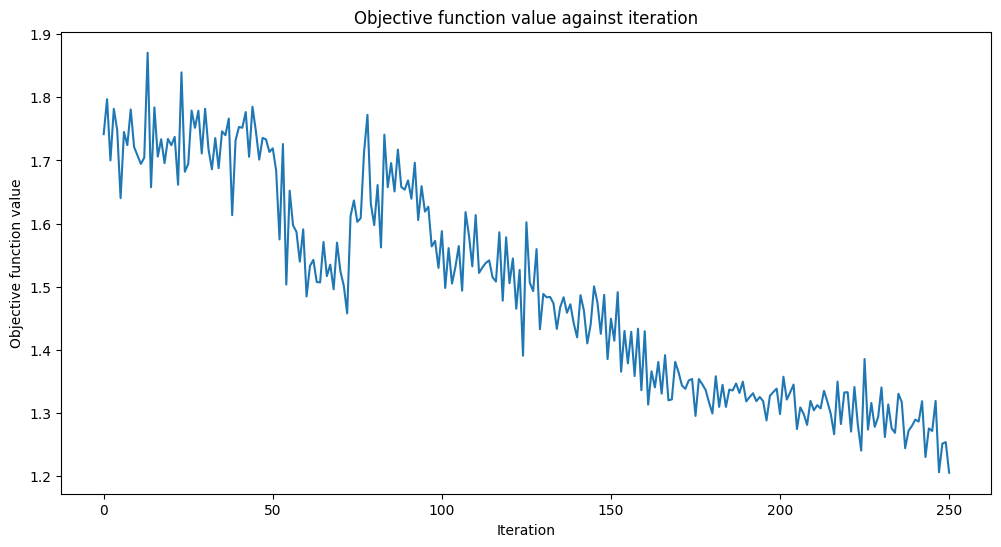

Testing accuracy: 0.76


In [29]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")

#Noisy Simulation with SPSA optimizer

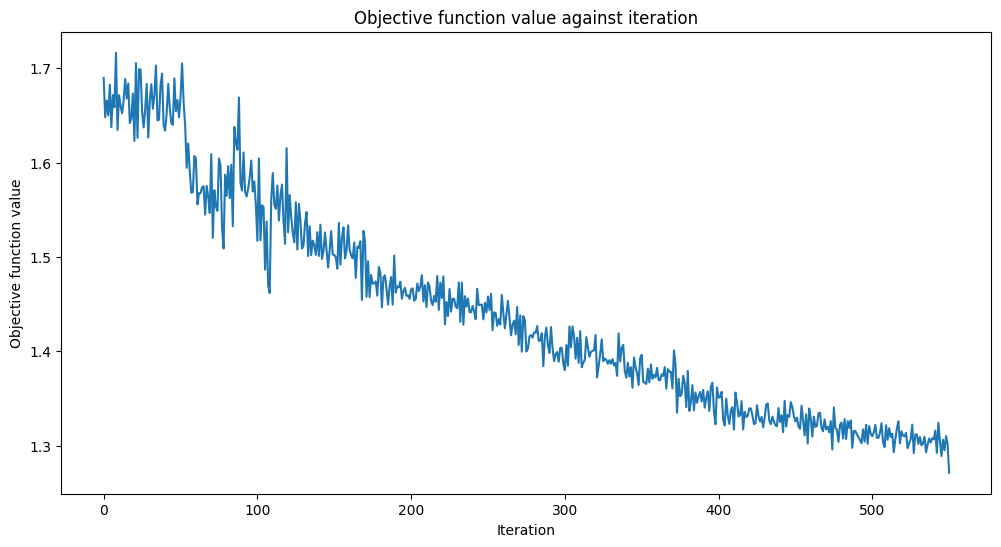

Testing accuracy: 0.76


In [46]:

vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SPSA(maxiter=250),
          quantum_instance=qi,callback=callback_graph
          )

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")

#Noisy Simulation with SPSA optimizer with Measurement Error Mitigation

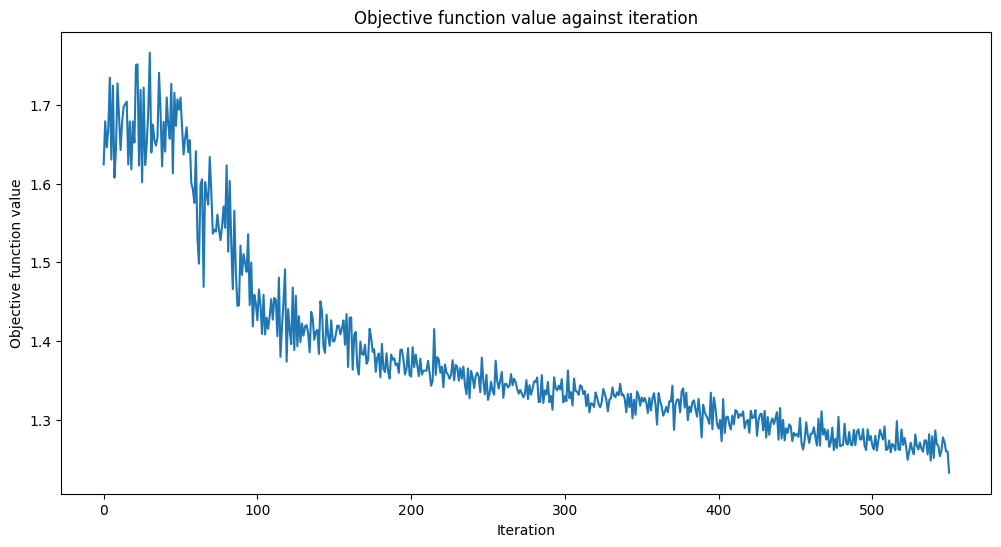

Testing accuracy: 0.76


In [47]:

vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SPSA(maxiter=250),
          quantum_instance=qi2,callback=callback_graph
          )
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train.to_numpy())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_test, y_test.to_numpy())
print(f"Testing accuracy: {score:0.2f}")